## Part 1


In [453]:
# imports
import wordcloud
from wordcloud import WordCloud
import json
from collections import defaultdict
from array import array
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jordi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jordi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [454]:
# load data
import json, gzip
from pathlib import Path

def iter_json_objects(path):
    opener = gzip.open if str(path).endswith('.gz') else open
    with opener(path, 'rt', encoding='utf-8') as f:
        first = f.read(1)
        f.seek(0)
        if first == '[':
            try:
                import ijson
                for obj in ijson.items(f, 'item'):
                    yield obj
            except ImportError:
                data = json.load(f)
                for obj in data:
                    yield obj
        else:
            for line in f:
                line = line.strip()
                if line:
                    yield json.loads(line)

NOTEBOOK_DIR = Path().resolve()
DATA_PATH = NOTEBOOK_DIR.parents[1] / "data" / "fashion_products_dataset.json"

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATA_PATH}. "
        "Please make sure 'fashion_products_dataset.json' is placed in the 'data/' folder at the repo root."
    )

print("Dataset path:", DATA_PATH)

records = list(iter_json_objects(DATA_PATH))
print(f"Loaded {len(records)} records successfully")

Dataset path: C:\Users\jordi\irwa-search-engine-g_019\data\fashion_products_dataset.json
Loaded 28080 records successfully


In [455]:
# prep
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def to_number(x):
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).replace(",", "").strip().lower()
    if "% off" in s:
        s = s.split("%")[0]
    if s in ["true", "false"]:
        return 1.0 if s == "true" else 0.0
    try:
        return float(s)
    except ValueError:
        return np.nan

def details_to_text(details):
    if not details:
        return ""
    out = []
    for d in details:
        if isinstance(d, dict):
            for key, val in d.items():
                out.append(f"{key} {val}")
    return " ".join(out)

def process_product(prod):
    title = prod.get("title", "")
    desc = prod.get("description", "")
    dets = details_to_text(prod.get("product_details"))
    full_text = f"{title} {desc} {dets}"
    tokens = word_tokenize(full_text)
    tokens = [t.lower() for t in tokens if t.isalnum()]
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2]
    clean_text = " ".join(tokens)
    return {
        "pid": prod.get("pid", ""),
        "title": title,
        "description": desc,
        "brand": prod.get("brand", ""),
        "category": prod.get("category", ""),
        "sub_category": prod.get("sub_category", ""),
        "product_details": prod.get("product_details", []),
        "seller": prod.get("seller", ""),
        "out_of_stock": to_number(prod.get("out_of_stock")),
        "selling_price": to_number(prod.get("selling_price")),
        "discount": to_number(prod.get("discount")),
        "actual_price": to_number(prod.get("actual_price")),
        "average_rating": to_number(prod.get("average_rating")),
        "url": prod.get("url", ""),
        "tokens": clean_text
    }

In [456]:
# process data
processed_data = [process_product(rec) for rec in iter_json_objects(DATA_PATH)]
products_df = pd.DataFrame(processed_data)
products_df.set_index("pid", inplace=True)
products_df.head(4)

,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,url,tokens
pid,,,,,,,,,,,,,,
TKPFCZ9EA7H5FYZH,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO2'}, {'Closure': 'El...",Shyam Enterprises,0.0,921.0,69.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid women multicolor track pant yorker track...
TKPFCZ9EJZV2UVRZ,Solid Men Blue Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005BLUE'}, {'Closure': 'Draw...",Shyam Enterprises,0.0,499.0,66.0,1499.0,3.9,https://www.flipkart.com/yorker-solid-men-blue...,solid men blue track pant yorker trackpant mad...
TKPFCZ9EHFCY5Z4Y,Solid Men Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO4'}, {'Closure': 'El...",Shyam Enterprises,0.0,931.0,68.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid men multicolor track pant yorker trackpa...
TKPFCZ9ESZZ7YWEF,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO3'}, {'Closure': 'El...",Shyam Enterprises,0.0,911.0,69.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid women multicolor track pant yorker track...


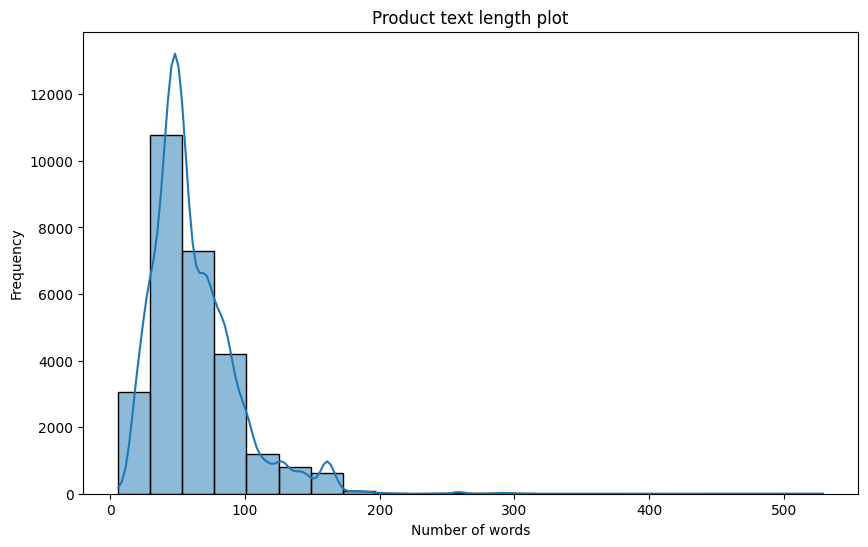

In [457]:
# plot text length
vocab_df = products_df.copy()
vocab_df['Wordcount'] = products_df['tokens'].fillna('').apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(vocab_df['Wordcount'], bins=22, kde=True)
plt.title('Product text length plot')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

In [458]:
# vocab info
whole_content = products_df['tokens'].fillna('').str.split().explode().tolist()
word_counts = Counter(whole_content)
vocab_dict = dict(word_counts)
print('Product vocabulary size is', len(vocab_dict))
sorted_dict = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
print('\nThe top 5 most appearing words are:')
for item in sorted_dict[:5]:
    print(item)

Product vocabulary size is 15877

The top 5 most appearing words are:
('fabric', 57213)
('neck', 56553)
('sleev', 50876)
('fit', 39523)
('type', 38701)


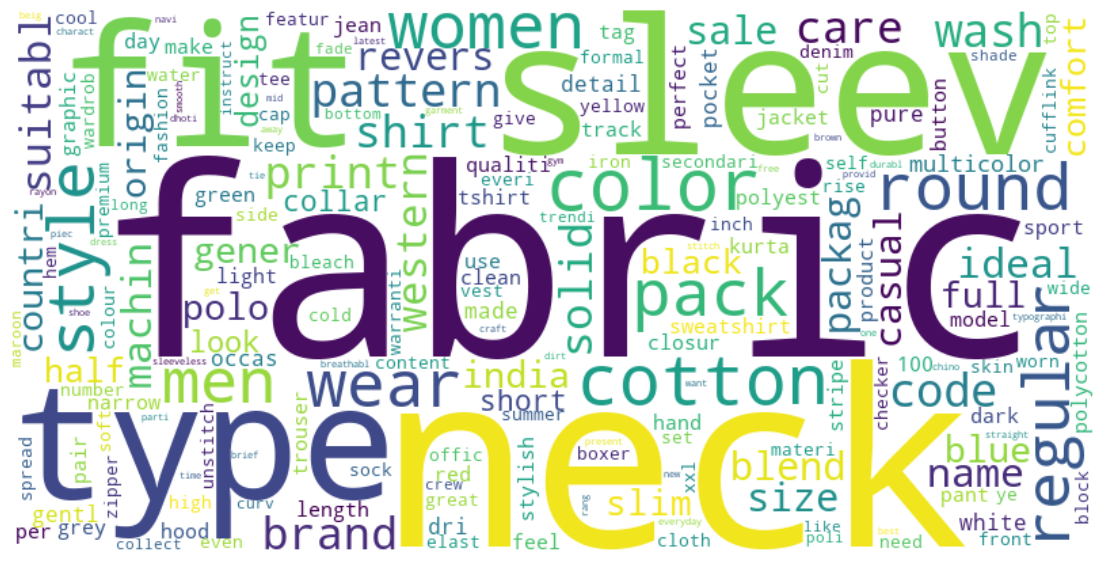

In [459]:
# word cloud
words_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vocab_dict)
plt.figure(figsize=(14,8))
plt.imshow(words_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [460]:
# top rated products
rated_df = products_df.copy()
rated_sorted = rated_df.sort_values(by='average_rating', ascending=False)
print('The following are the Top 5 Highest-Rated Products:')
rated_sorted.reset_index().drop(columns=['pid','url'], errors='ignore').head(5)

The following are the Top 5 Highest-Rated Products:


,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,tokens
0,Solid Women Round Neck Blue T-Shirt,,Oka,Clothing and Accessories,Topwear,"[{'Type': 'Round Neck'}, {'Sleeve': 'Half Slee...",OKANE,0.0,385.0,44.0,699.0,5.0,solid women round neck blue type round neck sl...
1,Printed Women Hooded Neck Black T-Shirt,,ATTIITU,Clothing and Accessories,Topwear,"[{'Type': 'Hooded Neck'}, {'Sleeve': 'Full Sle...",ATTIITUDE,0.0,549.0,60.0,1399.0,5.0,print women hood neck black type hood neck sle...
2,Printed Women Hooded Neck Grey T-Shirt,,ATTIITU,Clothing and Accessories,Topwear,"[{'Type': 'Hooded Neck'}, {'Sleeve': 'Full Sle...",Assiduus Distribution,0.0,909.0,35.0,1399.0,5.0,print women hood neck grey type hood neck slee...
3,Graphic Print Men Round Neck Blue T-Shirt,,Free Authori,Clothing and Accessories,Topwear,"[{'Type': 'Round Neck'}, {'Sleeve': 'Half Slee...",BioworldMerchandising,0.0,519.0,35.0,799.0,5.0,graphic print men round neck blue type round n...
4,"Solid Women Round Neck White, Black T-Shirt",Loosen up in this perfectlloose-fit black vest...,ATTIITU,Clothing and Accessories,Topwear,"[{'Type': 'Round Neck'}, {'Sleeve': 'Sleeveles...",Assiduus Distribution,0.0,649.0,35.0,999.0,5.0,solid women round neck white black loosen blac...


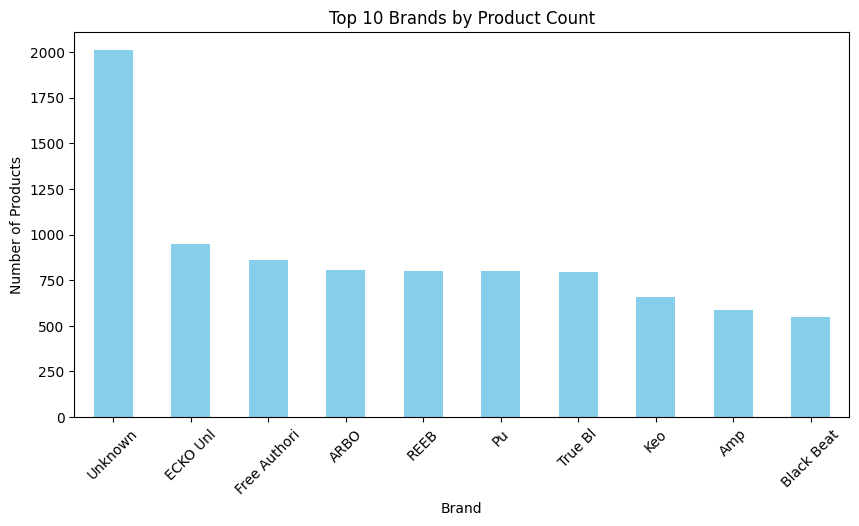

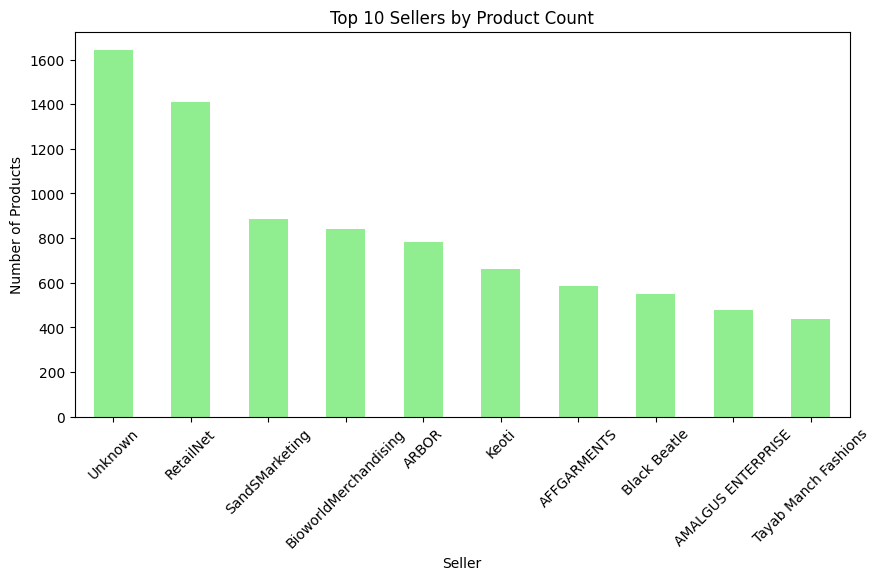

In [461]:
# brands and sellers
products_df['brand'] = products_df['brand'].fillna('Unknown')
products_df['brand'] = products_df['brand'].replace('', 'Unknown')
top_brands = products_df['brand'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_brands.plot(kind='bar', color='skyblue')
plt.title('Top 10 Brands by Product Count')
plt.xlabel('Brand')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()
products_df['seller'] = products_df['seller'].fillna('Unknown')
products_df['seller'] = products_df['seller'].replace('', 'Unknown')
top_sellers = products_df['seller'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_sellers.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Sellers by Product Count')
plt.xlabel('Seller')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()

## Part 2 — Indexing & Evaluation

In [462]:
# search engine
TEXT_COL = "tokens_plus" if "tokens_plus" in products_df.columns else "tokens"
from collections import defaultdict, Counter
import math

docs = products_df[TEXT_COL].fillna("")
doc_ids = products_df.index.astype(str).tolist()
vocab = {}
postings = defaultdict(list)
df = Counter()
for pid, text in zip(doc_ids, docs):
    terms = text.split()
    if not terms:
        continue
    tf = Counter(terms)
    for t, f in tf.items():
        if t not in vocab:
            vocab[t] = len(vocab)
        df[t] += 1
        postings[t].append((pid, f))
N = len(doc_ids)
idf = {t: math.log((N - df[t] + 0.5) / (df[t] + 0.5) + 1) for t in df}
doc_norm = defaultdict(float)
for t, plist in postings.items():
    w_idf = idf[t]
    for pid, f in plist:
        w = (1 + math.log(f)) * w_idf
        doc_norm[pid] += w * w
for pid in list(doc_norm.keys()):
    doc_norm[pid] = math.sqrt(doc_norm[pid])
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
def preprocess_query(q):
    toks = word_tokenize(q)
    toks = [t.lower() for t in toks if t.isalnum()]
    toks = [stemmer.stem(t) for t in toks if t not in stop_words and len(t) > 2]
    return toks
def search_and_rank(query, top_k=20):
    q_terms = preprocess_query(query)
    if not q_terms:
        return []
    term_lists = []
    for t in q_terms:
        if t not in postings:
            return []
        term_lists.append(set(pid for pid, _ in postings[t]))
    cand = set.intersection(*term_lists) if term_lists else set()
    if not cand:
        return []
    q_tf = Counter(q_terms)
    q_weights = {}
    q_norm = 0.0
    for t, f in q_tf.items():
        w = (1 + math.log(f)) * idf.get(t, 0.0)
        q_weights[t] = w
        q_norm += w*w
    q_norm = math.sqrt(q_norm) if q_norm > 0 else 1.0
    scores = defaultdict(float)
    for t, wq in q_weights.items():
        for pid, f in postings.get(t, []):
            if pid not in cand:
                continue
            wd = (1 + math.log(f)) * idf.get(t, 0.0)
            scores[pid] += wq * wd
    ranked = []
    for pid, s in scores.items():
        dnorm = doc_norm.get(pid, 1.0)
        ranked.append((pid, s / (dnorm * q_norm if dnorm else 1.0)))
    ranked.sort(key=lambda x: x[1], reverse=True)
    out = products_df.loc[[pid for pid, _ in ranked[:top_k]], ["title","brand","category","url"]].copy()
    out.insert(0, "pid", [pid for pid,_ in ranked[:top_k]])
    out["score"] = [score for _, score in ranked[:top_k]]
    return out
# test
display(search_and_rank("women full sleeve sweatshirt cotton", top_k=10))

,pid,title,brand,category,url,score
pid,,,,,,
SWSF9W4TCKGPSSZZ,SWSF9W4TCKGPSSZZ,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...,0.704995
SWSFYFFFJZN6P6ZW,SWSFYFFFJZN6P6ZW,Full Sleeve Printed Women Sweatshirt,MASH UNLIMIT,Clothing and Accessories,https://www.flipkart.com/mash-unlimited-full-s...,0.693323
SWSFZAUYZFAGEPKK,SWSFZAUYZFAGEPKK,Full Sleeve Printed Women Sweatshirt,BLACK SN,Clothing and Accessories,https://www.flipkart.com/black-snow-full-sleev...,0.690061
SWSFYTYMNTBNARUN,SWSFYTYMNTBNARUN,Full Sleeve Solid Women Sweatshirt,ARBO,Clothing and Accessories,https://www.flipkart.com/arbour-full-sleeve-so...,0.680882
SWSF9W3ZHHJFQFJF,SWSF9W3ZHHJFQFJF,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...,0.659757
SWSF9W4HABG6BBY4,SWSF9W4HABG6BBY4,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.624541
SWSF9W4TBFMF3GZA,SWSF9W4TBFMF3GZA,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.619777
SWSFYPHKZKPRWHPV,SWSFYPHKZKPRWHPV,Full Sleeve Printed Women Sweatshirt,Free Authori,Clothing and Accessories,https://www.flipkart.com/free-authority-full-s...,0.619544
SWSF9W4TTB2M9ZXT,SWSF9W4TTB2M9ZXT,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.619329


In [463]:
# frequent tokens
from collections import Counter
from random import sample
top_terms = Counter(" ".join(products_df[TEXT_COL].fillna("")).split()).most_common(200)
filtered = [t for t,_ in top_terms if t not in stop_words and len(t) > 3 and t not in {"size","color"}]
print(filtered[:20])

['fabric', 'neck', 'sleev', 'type', 'cotton', 'pack', 'style', 'wear', 'round', 'women', 'regular', 'pattern', 'wash', 'code', 'care', 'print', 'shirt', 'solid', 'brand', 'suitabl']


In [464]:
# test queries
test_queries = [
    "women cotton shirt",
    "round neck shirt",
    "solid pattern wear",
    "men regular fit",
    "printed cotton fabric"
]
test_queries

['women cotton shirt',
 'round neck shirt',
 'solid pattern wear',
 'men regular fit',
 'printed cotton fabric']

In [465]:
# run queries
for q in test_queries:
    print(f"\nQuery: {q}")
    display(search_and_rank(q, top_k=5))


Query: women cotton shirt


,pid,title,brand,category,url,score
pid,,,,,,
SHTFTK76BEPJKDZ7,SHTFTK76BEPJKDZ7,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.434020
SHTFTJZ4XKAVFCNH,SHTFTJZ4XKAVFCNH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.406858
SHTFTJZ4GZZYTFYN,SHTFTJZ4GZZYTFYN,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.406858
SHTFTJW9BUDMGUGV,SHTFTJW9BUDMGUGV,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.404611
SHTFTJWAV7JGQHCB,SHTFTJWAV7JGQHCB,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.404611



Query: round neck shirt


,pid,title,brand,category,url,score
pid,,,,,,
TSHFW9CRK3GZDAGX,TSHFW9CRK3GZDAGX,Printed Men Round Neck Black T-Shirt,Rose We,Clothing and Accessories,https://www.flipkart.com/rose-wear-printed-men...,0.520091
TSHEH6VCUKBRRKPS,TSHEH6VCUKBRRKPS,Solid Men Round Neck Black T-Shirt (Pack of 2),The Arch,Clothing and Accessories,https://www.flipkart.com/archer-solid-men-roun...,0.495091
TSHFW9CRBTZTKCGN,TSHFW9CRBTZTKCGN,Printed Men Round Neck White T-Shirt,Rose We,Clothing and Accessories,https://www.flipkart.com/rose-wear-printed-men...,0.491707
TSHFW9CJYKXB3NKD,TSHFW9CJYKXB3NKD,Printed Women Round Neck Black T-Shirt,Rose We,Clothing and Accessories,https://www.flipkart.com/rose-wear-printed-men...,0.483866
TSHFZZRSPUF3NQYM,TSHFZZRSPUF3NQYM,Printed Women Round Neck Black T-Shirt,Styleska,Clothing and Accessories,https://www.flipkart.com/styleskart-printed-me...,0.479949



Query: solid pattern wear


,pid,title,brand,category,url,score
pid,,,,,,
SHTFTJZ4XKAVFCNH,SHTFTJZ4XKAVFCNH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.352552
SHTFTJZ4GZZYTFYN,SHTFTJZ4GZZYTFYN,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.352552
SHTFTJZ4RETDZMQH,SHTFTJZ4RETDZMQH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.346447
SHTFTJZ4AARXMGJ8,SHTFTJZ4AARXMGJ8,Men Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.332736
SHTFMKQZU3AGGTKX,SHTFMKQZU3AGGTKX,Men Slim Fit Solid Casual Shirt,SUR,Clothing and Accessories,https://www.flipkart.com/sur-t-men-solid-casua...,0.313833



Query: men regular fit


,pid,title,brand,category,url,score
pid,,,,,,
TSHFN6QANCZHVQZB,TSHFN6QANCZHVQZB,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-solid-men-roun...,0.376444
TSHFN6QA9RZDMFGS,TSHFN6QA9RZDMFGS,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-solid-men-roun...,0.344581
TSHFN6QAHTJ523ZR,TSHFN6QAHTJ523ZR,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-solid-men-roun...,0.344581
SHTFWAP5WUVXS3PQ,SHTFWAP5WUVXS3PQ,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.332885
TSHF2DZ6YS662GFQ,TSHF2DZ6YS662GFQ,Solid Men V-neck White T-Shirt,rockha,Clothing and Accessories,https://www.flipkart.com/rockhard-solid-men-v-...,0.331670



Query: printed cotton fabric


,pid,title,brand,category,url,score
pid,,,,,,
SHTFTMXZHCAJXZGR,SHTFTMXZHCAJXZGR,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.428962
SHTFJZC2ZHMEUFVT,SHTFJZC2ZHMEUFVT,Women Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories,https://www.flipkart.com/sur-t-men-printed-cas...,0.414693
SHTFJZC26VXWPAR3,SHTFJZC26VXWPAR3,Men Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories,https://www.flipkart.com/sur-t-men-printed-cas...,0.414462
SHTFTKRSRWHN2THK,SHTFTKRSRWHN2THK,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.406711
SHTFWAP5A3XHS2TM,SHTFWAP5A3XHS2TM,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.401566


In [466]:
# metrics
def precision_at_k(y_true, y_pred, k=10):
    pred = y_pred[:k]
    hits = sum(y_true.get(pid, 0) for pid in pred)
    return hits / float(k)
def recall_at_k(y_true, y_pred, k=10):
    pred = y_pred[:k]
    rel_total = sum(y_true.values())
    hits = sum(y_true.get(pid, 0) for pid in pred)
    return hits / max(1, rel_total)
def ap_at_k(y_true, y_pred, k=10):
    ap, hits = 0.0, 0
    for i, pid in enumerate(y_pred[:k], start=1):
        if y_true.get(pid, 0):
            hits += 1
            ap += hits / i
    rel_total = sum(y_true.values())
    return ap / max(1, min(rel_total, k))
def f1_at_k(y_true, y_pred, k=10):
    p = precision_at_k(y_true, y_pred, k)
    r = recall_at_k(y_true, y_pred, k)
    return 2*p*r / (p + r) if (p+r) > 0 else 0.0
def map_score(list_of_labeldicts, list_of_rankings, k=10):
    aps = [ap_at_k(y_true, y_pred, k) for y_true, y_pred in zip(list_of_labeldicts, list_of_rankings)]
    return float(np.mean(aps)) if aps else 0.0
def mrr(list_of_labeldicts, list_of_rankings, k=10):
    rr = []
    for y_true, y_pred in zip(list_of_labeldicts, list_of_rankings):
        rank = None
        for i, pid in enumerate(y_pred[:k], start=1):
            if y_true.get(pid, 0):
                rank = i; break
        rr.append(1.0/rank if rank else 0.0)
    return float(np.mean(rr)) if rr else 0.0
def ndcg_at_k(y_true, y_pred, k=10):
    gains = [y_true.get(pid, 0) for pid in y_pred[:k]]
    dcg = sum(g / math.log2(i+2) for i, g in enumerate(gains))
    ideal_gains = sorted(y_true.values(), reverse=True)[:k]
    idcg = sum(g / math.log2(i+2) for i, g in enumerate(ideal_gains))
    return dcg / idcg if idcg > 0 else 0.0

In [467]:
# eval
val = pd.read_csv("../../data/validation_labels.csv")
val["pid"] = val["pid"].astype(str)
predef_queries = {
    1: "women full sleeve sweatshirt cotton",
    2: "men slim jeans blue",
}
K = 10
metric_table = []
all_labeldicts, all_rankings = [], []
for qid, qtext in predef_queries.items():
    sub = val[val["query_id"] == qid].copy()
    labeldict = dict(zip(sub["pid"], sub["labels"]))
    ranked_df = search_and_rank(qtext, top_k=len(sub))
    ranked_pids = [pid for pid in ranked_df["pid"].tolist() if pid in labeldict]
    tail = [pid for pid in sub["pid"].tolist() if pid not in set(ranked_pids)]
    final_order = ranked_pids + tail
    P = precision_at_k(labeldict, final_order, K)
    R = recall_at_k(labeldict, final_order, K)
    AP = ap_at_k(labeldict, final_order, K)
    F1 = f1_at_k(labeldict, final_order, K)
    N = ndcg_at_k(labeldict, final_order, K)
    metric_table.append([qid, P, R, AP, F1, N])
    all_labeldicts.append(labeldict)
    all_rankings.append(final_order)
MAP = map_score(all_labeldicts, all_rankings, K)
MRR = mrr(all_labeldicts, all_rankings, K)
for row in metric_table:
    qid, P, R, AP, F1, N = row
    print(f"{qid} {P:.3f} {R:.3f} {AP:.3f} {F1:.3f} {N:.3f}")
print(f"MAP {MAP:.3f}")
print(f"MRR {MRR:.3f}")

1 0.700 0.538 0.508 0.609 0.703
2 0.700 0.700 0.591 0.700 0.756
MAP 0.549
MRR 1.000


In [468]:
# helpers
def evaluate_labeled_query(results_df, rel_idx, k=10):
    ranking, y_true = finalize_labels(results_df, rel_idx)
    P  = precision_at_k(y_true, ranking, k)
    R  = recall_at_k(y_true, ranking, k)
    AP = ap_at_k(y_true, ranking, k)
    F1 = f1_at_k(y_true, ranking, k)
    N  = ndcg_at_k(y_true, ranking, k)
    print(f"P@{k}={P:.3f} R@{k}={R:.3f} AP@{k}={AP:.3f} F1@{k}={F1:.3f} NDCG@{k}={N:.3f}")
    return ranking, y_true

def label_query_noinput(q, top_k=30):
    df = search_and_rank(q, top_k=top_k).reset_index(drop=True)
    df.insert(0, "idx", range(len(df)))
    display(df[["idx","pid","title","brand","category"]])
    print("\nSet rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}\nThen run: ranking, y_true = finalize_labels(df, rel_idx)")
    return df

def finalize_labels(df, rel_idx):
    rel_pids = set(df.loc[list(rel_idx), "pid"])
    y_true = {pid: (pid in rel_pids) for pid in df["pid"].tolist()}
    ranking = df["pid"].tolist()
    return ranking, y_true

In [469]:
def run_one_query(q, rel_idx, k=10):
    df = label_query_noinput(q, top_k=30)
    ranking, y_true = evaluate_labeled_query(df, rel_idx, k=k)
    print("Relevant PIDs:", [df.loc[i, "pid"] for i in sorted(rel_idx)])
    print("Top-10 ranking PIDs:", ranking[:10])
    return df, ranking, y_true
# example
df, ranking, y_true = run_one_query("men slim jeans blue", {0, 1}, k=10)

,idx,pid,title,brand,category
0,0,JEAFVDRJZ5RWAFHB,Slim Men Blue Jeans,Reliable Ca,Clothing and Accessories
1,1,JEAFVPFUA97ZETDB,Slim Men Blue Jeans,TimeO,Clothing and Accessories
2,2,JEAFV8WURBM7PGYT,Slim Men Blue Jeans,Reliable Ca,Clothing and Accessories
3,3,JEAFSKYHZHSZZC9S,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
4,4,JEAFRAQXEKGUPNUN,Slim Men Blue Jeans,Lev,Clothing and Accessories
5,5,JEAFQF6JBUSEXHVF,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
6,6,JEAFSKYHRVZSABPR,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
7,7,JEAFSKYHTE76YWH7,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
8,8,JEAFSKYHSYMTKEJD,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
9,9,JEAEVJGUSXRNSHRY,Slim Men Dark Blue Jeans,Absolu,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.200 R@10=1.000 AP@10=1.000 F1@10=0.333 NDCG@10=1.000
Relevant PIDs: ['JEAFVDRJZ5RWAFHB', 'JEAFVPFUA97ZETDB']
Top-10 ranking PIDs: ['JEAFVDRJZ5RWAFHB', 'JEAFVPFUA97ZETDB', 'JEAFV8WURBM7PGYT', 'JEAFSKYHZHSZZC9S', 'JEAFRAQXEKGUPNUN', 'JEAFQF6JBUSEXHVF', 'JEAFSKYHRVZSABPR', 'JEAFSKYHTE76YWH7', 'JEAFSKYHSYMTKEJD', 'JEAEVJGUSXRNSHRY']


In [470]:
df_ws, ranking_ws, y_true_ws = run_one_query("women cotton shirt", {}, k=10)

,idx,pid,title,brand,category
0,0,SHTFTK76BEPJKDZ7,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
1,1,SHTFTJZ4XKAVFCNH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
2,2,SHTFTJZ4GZZYTFYN,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
3,3,SHTFTJW9BUDMGUGV,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
4,4,SHTFTJWAV7JGQHCB,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
5,5,SHTFTJWB5PUSRMAC,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
6,6,SHTFTJW9N7HR4Z5R,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
7,7,SHTFTJZ4RETDZMQH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
8,8,SHTFAHEYNJFTZDNN,Women Regular Fit Solid Casual Shirt,Purple Sta,Clothing and Accessories
9,9,SHTFWAP5A3XHS2TM,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['SHTFTK76BEPJKDZ7', 'SHTFTJZ4XKAVFCNH', 'SHTFTJZ4GZZYTFYN', 'SHTFTJW9BUDMGUGV', 'SHTFTJWAV7JGQHCB', 'SHTFTJWB5PUSRMAC', 'SHTFTJW9N7HR4Z5R', 'SHTFTJZ4RETDZMQH', 'SHTFAHEYNJFTZDNN', 'SHTFWAP5A3XHS2TM']


In [471]:
df_hf, ranking_hf, y_true_hf = run_one_query("round neck shirt", {1,2,3,4,5}, k=10)

,idx,pid,title,brand,category
0,0,TSHFW9CRK3GZDAGX,Printed Men Round Neck Black T-Shirt,Rose We,Clothing and Accessories
1,1,TSHEH6VCUKBRRKPS,Solid Men Round Neck Black T-Shirt (Pack of 2),The Arch,Clothing and Accessories
2,2,TSHFW9CRBTZTKCGN,Printed Men Round Neck White T-Shirt,Rose We,Clothing and Accessories
3,3,TSHFW9CJYKXB3NKD,Printed Women Round Neck Black T-Shirt,Rose We,Clothing and Accessories
4,4,TSHFZZRSPUF3NQYM,Printed Women Round Neck Black T-Shirt,Styleska,Clothing and Accessories
5,5,TSHFYZ2YGGMB8CGK,Printed Men Round Neck Black T-Shirt,Styleska,Clothing and Accessories
6,6,TSHEZP37J8S3SREJ,Solid Men Round Neck Black T-Shirt,HUMBE,Clothing and Accessories
7,7,TSHFW9CRFQCQCH4Q,Printed Women Round Neck Grey T-Shirt,Rose We,Clothing and Accessories
8,8,TSHFZ8ZJKJVF5UJH,Printed Women Round Neck Black T-Shirt,True Bl,Clothing and Accessories
9,9,TSHFXHHVSMNQDHSH,Printed Women Round Neck Multicolor T-Shirt,Rose We,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.500 R@10=1.000 AP@10=0.710 F1@10=0.667 NDCG@10=0.782
Relevant PIDs: ['TSHEH6VCUKBRRKPS', 'TSHFW9CRBTZTKCGN', 'TSHFW9CJYKXB3NKD', 'TSHFZZRSPUF3NQYM', 'TSHFYZ2YGGMB8CGK']
Top-10 ranking PIDs: ['TSHFW9CRK3GZDAGX', 'TSHEH6VCUKBRRKPS', 'TSHFW9CRBTZTKCGN', 'TSHFW9CJYKXB3NKD', 'TSHFZZRSPUF3NQYM', 'TSHFYZ2YGGMB8CGK', 'TSHEZP37J8S3SREJ', 'TSHFW9CRFQCQCH4Q', 'TSHFZ8ZJKJVF5UJH', 'TSHFXHHVSMNQDHSH']


In [472]:
df_fd, ranking_fd, y_true_fd = run_one_query("solid pattern regular wear", { }, k=10)

,idx,pid,title,brand,category
0,0,SHTFTJZ4XKAVFCNH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
1,1,SHTFTJZ4GZZYTFYN,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
2,2,SHTFTJZ4RETDZMQH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
3,3,SHTFTJZ4AARXMGJ8,Men Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
4,4,TSHFN6QANCZHVQZB,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories
5,5,TSHEHG2922TRGAFA,Solid Women V-neck White T-Shirt,The Arch,Clothing and Accessories
6,6,SHTFTK76BEPJKDZ7,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
7,7,SHTFUFSXW5T6EVHX,Women Regular Fit Solid Casual Shirt,Mett,Clothing and Accessories
8,8,SHTF7Y285HFZGEVW,Women Regular Fit Solid Casual Shirt,Purple Sta,Clothing and Accessories
9,9,SHTFAHEYNJFTZDNN,Women Regular Fit Solid Casual Shirt,Purple Sta,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['SHTFTJZ4XKAVFCNH', 'SHTFTJZ4GZZYTFYN', 'SHTFTJZ4RETDZMQH', 'SHTFTJZ4AARXMGJ8', 'TSHFN6QANCZHVQZB', 'TSHEHG2922TRGAFA', 'SHTFTK76BEPJKDZ7', 'SHTFUFSXW5T6EVHX', 'SHTF7Y285HFZGEVW', 'SHTFAHEYNJFTZDNN']


In [473]:
df_rs, ranking_rs, y_true_rs = run_one_query("men regular fit", { 3,4}, k=10)

,idx,pid,title,brand,category
0,0,TSHFN6QANCZHVQZB,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories
1,1,TSHFN6QA9RZDMFGS,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories
2,2,TSHFN6QAHTJ523ZR,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories
3,3,SHTFWAP5WUVXS3PQ,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
4,4,TSHF2DZ6YS662GFQ,Solid Men V-neck White T-Shirt,rockha,Clothing and Accessories
5,5,TSHF2DZ7JKNG8ZDM,Solid Men Round Neck Blue T-Shirt,rockha,Clothing and Accessories
6,6,SHTFTMXZHCAJXZGR,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
7,7,TSHF744KRJZSMXCR,Printed Men Round Neck Multicolor T-Shirt (Pa...,AXMA,Clothing and Accessories
8,8,TSHF73YH4XEGEBZG,Printed Men Round Neck Multicolor T-Shirt (Pa...,AXMA,Clothing and Accessories
9,9,TSHF7429V9FTUESE,Printed Men Round Neck Multicolor T-Shirt (Pa...,AXMA,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.200 R@10=1.000 AP@10=0.325 F1@10=0.333 NDCG@10=0.501
Relevant PIDs: ['SHTFWAP5WUVXS3PQ', 'TSHF2DZ6YS662GFQ']
Top-10 ranking PIDs: ['TSHFN6QANCZHVQZB', 'TSHFN6QA9RZDMFGS', 'TSHFN6QAHTJ523ZR', 'SHTFWAP5WUVXS3PQ', 'TSHF2DZ6YS662GFQ', 'TSHF2DZ7JKNG8ZDM', 'SHTFTMXZHCAJXZGR', 'TSHF744KRJZSMXCR', 'TSHF73YH4XEGEBZG', 'TSHF7429V9FTUESE']


In [474]:
df_rs, ranking_rs, y_true_rs = run_one_query("printed cotton fabric", {}, k=10)

,idx,pid,title,brand,category
0,0,SHTFTMXZHCAJXZGR,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
1,1,SHTFJZC2ZHMEUFVT,Women Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
2,2,SHTFJZC26VXWPAR3,Men Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
3,3,SHTFTKRSRWHN2THK,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
4,4,SHTFWAP5A3XHS2TM,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
5,5,SHTFWAP5KFUQKM3R,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
6,6,SHTFWAP5WUVXS3PQ,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
7,7,SHTFJZC4GJ7Q8MUM,Women Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
8,8,SHTFJZC2TXC9CHPH,Women Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
9,9,SHTFU6DANFWNZSG7,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['SHTFTMXZHCAJXZGR', 'SHTFJZC2ZHMEUFVT', 'SHTFJZC26VXWPAR3', 'SHTFTKRSRWHN2THK', 'SHTFWAP5A3XHS2TM', 'SHTFWAP5KFUQKM3R', 'SHTFWAP5WUVXS3PQ', 'SHTFJZC4GJ7Q8MUM', 'SHTFJZC2TXC9CHPH', 'SHTFU6DANFWNZSG7']


## PART 3 - Ranking & Filtering

### Definition of the functions

In [475]:
# Load data from Part 2
index = postings
idf = idf
df = products_df.copy()
tf = {}

# Build tf dict
for term, plist in index.items():
    tf[term] = {str(doc_id): freq for doc_id, freq in plist}

print("Index loaded from Part 2")
print(f"Terms in index: {len(index)}")
print(f"Example entry: {list(index.items())[:1]}")

Index loaded from Part 2
Terms in index: 15877
Example entry: [('solid', [('TKPFCZ9EA7H5FYZH', 2), ('TKPFCZ9EJZV2UVRZ', 2), ('TKPFCZ9EHFCY5Z4Y', 2), ('TKPFCZ9ESZZ7YWEF', 2), ('TKPFCZ9EVXKBSUD7', 2), ('TKPFCZ9EFK9DNWDA', 2), ('TKPFDABN3GXYPFHE', 2), ('TKPFCZ9ESGZYT8NH', 2), ('TKPFCZ9DYU33FFXS', 2), ('TKPFDABN4NQFVKZY', 2), ('TKPFZFSHHACG3FHC', 2), ('TKPFZFSHQPDRGZTM', 2), ('TKPFZFSH3F9ZA7C6', 2), ('TKPFCZ9EHCNAPKPU', 2), ('TKPFDACEXAWUHGR7', 2), ('TKPFD3K62JB9PEMR', 2), ('TKPFCZ9EZDPZR5AH', 2), ('TKPFWBGVGU9FCAYX', 2), ('TKPFCZ9EVM2GZ4GF', 2), ('TKPFWAG7YFWPMG5Y', 2), ('TKPFCZ9E2UC3DR3F', 2), ('TKPFCZ9ECDYYDNKA', 2), ('SWTFYHP2QQQYEGRJ', 2), ('SWTFYQQ5Z7VT4CFH', 2), ('SWTFYHPQGHQDHKHY', 2), ('SWTFYHPVHZSVMHYR', 2), ('SWTFYHPKSZDBSBGU', 2), ('RNCFT93XGKXHBHYJ', 2), ('TSHFWTPXBG5SZDV7', 3), ('SHTFVVEHGJJTM4QN', 2), ('SHTFVVEHJKNZ7VNR', 2), ('TSHFWTPXPEDHXUQQ', 3), ('SHTFVVEHWHRGQMKY', 2), ('TSHFZ67FC4P49NFW', 3), ('TSHFWYV9YZABZYBV', 2), ('TSHFZ67FFMRPUCAH', 3), ('SHTFVVEHFY5F4QVH', 2), (

In [476]:
# Query preprocessing function
def query_normalizer(line):
  tokens = word_tokenize(line)
  stop_words = set(stopwords.words("english"))
  stemmer = PorterStemmer()
  
  # Remove stopwords and stem
  relevant_tokens = [
        stemmer.stem(token.lower()) for token in tokens
        if token.isalnum() and not token.startswith(("http", "www"))
        and token.lower() not in stop_words and len(token) > 2
    ]
  
  return relevant_tokens

In [477]:
# TF-IDF with cosine similarity

def search_tf_cos(query, index, idf, tf, top_k=20):
    terms = query_normalizer(query)
    docs, found = None, False
    for term in terms:
        if term in index:
            found = True
            term_docs = {posting[0] for posting in index[term]}
            docs = term_docs if docs is None else docs & term_docs
    if not found or not docs:
        return []
    ranked_docs = tf_cos_ranker(terms, list(docs), index, idf, tf)
    return ranked_docs[:top_k]


def tf_cos_ranker(terms, docs, index, idf, tf):
    doc_vectors = defaultdict(lambda: [0] * len(terms))
    query_vector = [0] * len(terms)
    query_terms_count = Counter(terms)

    for i, term in enumerate(terms):
        # query TF-IDF
        tfq = query_terms_count[term]
        q_w = (1.0 + np.log(tfq)) * idf.get(term, 0.0) if tfq > 0 else 0.0
        query_vector[i] = q_w

        for doc, _ in index.get(term, []):
            if doc in docs:
                tf_doc_raw = tf.get(term, {}).get(doc, 0.0)
                w_td = (1.0 + np.log(tf_doc_raw)) * idf.get(term, 0.0) if tf_doc_raw > 0 else 0.0
                doc_vectors[doc][i] = w_td

    # cosine similarity
    q_norm = np.linalg.norm(query_vector) or 1.0
    doc_scores = []
    for doc, vec in doc_vectors.items():
        d_norm = np.linalg.norm(vec) or 1.0
        score = float(np.dot(vec, query_vector) / (d_norm * q_norm))
        doc_scores.append((doc, score))
    doc_scores.sort(key=lambda x: x[1], reverse=True)
    return doc_scores

In [ ]:
# BM25 ranking

def search_bm25(query, index, idf, tf, df, top_k=20):
    query = query_normalizer(query)
    docs = None

    for term in query:
        try:
            term_docs = {posting[0] for posting in index[term]}
            docs = term_docs if docs is None else docs & term_docs
        except KeyError:
            return []

    docs = list(docs) if docs else []
    ranked_docs = bm25_rank_documents(query=query, docs=docs, index=index, idf=idf, tf=tf, df=df)
    return ranked_docs[:top_k]


def bm25_rank_documents(query, docs, index, idf, tf, df, k1=1.5, b=0.75):
    # compute doc length
    text_col = globals().get("TEXT_COL", "tokens")
    if "doc_length" not in df.columns:
        if text_col in df.columns:
            df["doc_length"] = df[text_col].fillna("").apply(lambda x: len(str(x).split()))
        else:
            df["doc_length"] = df["title"].fillna("").apply(lambda x: len(str(x).split()))
    avgdl = float(df["doc_length"].mean()) if not df["doc_length"].empty else 1.0

    doc_scores = defaultdict(float)
    for term in query:
        if term not in index:
            continue
        term_idf = idf.get(term, 0.0)
        postings_term = index[term]
        for doc, positions in postings_term:
            if doc not in docs:
                continue
            if isinstance(positions, (int, float)):
                term_freq = float(positions)
            elif isinstance(positions, (list, tuple)):
                term_freq = float(len(positions))
            else:
                try:
                    term_freq = float(positions)
                except Exception:
                    term_freq = 1.0

            doc_length = float(df.loc[doc, "doc_length"])
            # BM25 formula
            tf_component = (term_freq * (k1 + 1)) / (term_freq + k1 * (1 - b + b * (doc_length / avgdl)))
            doc_scores[doc] += term_idf * tf_component

    ranked = [(doc, score) for doc, score in doc_scores.items()]
    ranked.sort(key=lambda x: x[1], reverse=True)
    return ranked

In [ ]:
from datetime import datetime

def MySearch(query, index, idf, tf, df, top_k=20):
    terms = query_normalizer(query)
    docs, found = None, False

    for term in terms:
        if term in index:
            found = True
            term_docs = {posting[0] for posting in index[term]}
            docs = term_docs if docs is None else docs & term_docs

    if not found or not docs:
        return []

    ranked_docs = MyRanking(terms, list(docs), index, idf, tf, df)
    return ranked_docs[:top_k]

def MyRanking(terms, docs, index, idf, tf, df, TIW=0.9):
    # Custom score: TF-IDF + metadata boosts
    rating_max = df["average_rating"].max() if "average_rating" in df.columns else 5.0
    discount_max = df["discount"].max() if "discount" in df.columns else 100.0

    doc_vectors = defaultdict(lambda: [0]*len(terms))
    query_vector = [0]*len(terms)
    query_counts = Counter(terms)

    # build vectors
    for i, term in enumerate(terms):
        if term in index:
            tfq = 1 + np.log(query_counts[term])
            query_vector[i] = tfq * idf.get(term, 0)

            for doc, freq in index[term]:
                if doc in docs:
                    tf_doc = tf.get(term, {}).get(doc, 0)
                    doc_vectors[doc][i] = tf_doc * idf.get(term, 0)

    q_norm = np.linalg.norm(query_vector) or 1.0
    doc_scores = []

    for doc, vec in doc_vectors.items():
        doc_norm = np.linalg.norm(vec) or 1.0
        cosine_score = float(np.dot(vec, query_vector) / (doc_norm * q_norm))
        if cosine_score == 0:
            continue

        # get metadata
        try:
            rating_raw = df.loc[doc, "average_rating"]
            rating = float(rating_raw) / rating_max if pd.notna(rating_raw) else 0.0
        except Exception:
            rating = 0.0

        try:
            discount_raw = df.loc[doc, "discount"]
            discount = float(discount_raw) / discount_max if pd.notna(discount_raw) else 0.0
        except Exception:
            discount = 0.0

        recency = 0.0
        if "date_added" in df.columns:
            try:
                doc_date = pd.to_datetime(df.loc[doc, "date_added"])
                days = (datetime.now() - doc_date).days
                recency = max(0, 1 - days/180)
            except Exception:
                pass

        boost = 1.0 + 0.1*rating + 0.05*discount + 0.1*recency
        final_score = TIW * cosine_score + (1 - TIW) * cosine_score * boost
        doc_scores.append((doc, final_score))

    ranked = sorted(doc_scores, key=lambda x: x[1], reverse=True)
    return ranked

### Ranking Comparison

In [480]:
# Test TF-IDF ranking

top = 20
print('========= TF-IDF + cosine ranking =========\n')
query = "women full sleeve sweatshirt cotton"
print(f"Query: {query}\n")

ranked_docs = search_tf_cos(query, index, idf, tf)

n_results = min(top, len(ranked_docs))
print(f"\n======================\nTop {n_results} results out of {len(ranked_docs)} for the searched query:\n")

for d_id, score in ranked_docs[:top]:
    if d_id in products_df.index:
        row = products_df.loc[d_id]
        print(f"Product ID: {d_id} (Score: {score:.4f})")
        print(f"  Title: {row['title']}")
        print(f"  Brand: {row.get('brand', 'N/A')}")
        print(f"  Category: {row.get('category', 'N/A')}")
        print(f"  URL: {row.get('url', 'N/A')}\n")
    else:
        print(f"Skipped {d_id} (not found in products_df index)")

========= TF-IDF + cosine ranking =========

Query: women full sleeve sweatshirt cotton


Top 20 results out of 20 for the searched query:

Product ID: SWSFXNFSHFZKXEZE (Score: 0.9997)
  Title: Full Sleeve Graphic Print Women Sweatshirt
  Brand: Free Authori
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/free-authority-full-sleeve-graphic-print-men-sweatshirt/p/itm03a439fac8f53?pid=SWSFXNFSHFZKXEZE&lid=LSTSWSFXNFSHFZKXEZEVJGI2F&marketplace=FLIPKART&srno=b_6_220&otracker=browse&fm=organic&iid=e1d03c76-76f5-4e8c-be54-cfa3328ade37.SWSFXNFSHFZKXEZE.SEARCH&ssid=ndokzb5v8w0000001612105860057

Product ID: SWSFUY89DXWXDHUG (Score: 0.9993)
  Title: Full Sleeve Printed Women Sweatshirt
  Brand: Pu
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/puma-full-sleeve-printed-men-sweatshirt/p/itm47c5007cb5b57?pid=SWSFUY89DXWXDHUG&lid=LSTSWSFUY89DXWXDHUGN5KJWS&marketplace=FLIPKART&srno=b_16_621&otracker=browse&fm=organic&iid=4af6b98b-fc84-4f35-93ac-aaf5362f19b4

In [481]:
# Test BM25 ranking

top = 20
print('========= BM25 ranking =========\n')

query = "women full sleeve sweatshirt cotton"
print(f"Query: {query}\n")

# compute doc length
products_df["doc_length"] = products_df["title"].fillna("").apply(lambda x: len(str(x).split()))
df["doc_length"] = products_df["doc_length"]

ranked_docs = search_bm25(query, index, idf, tf, df)

n_results = min(top, len(ranked_docs))
print(f"\n======================\nTop {n_results} results out of {len(ranked_docs)} for the searched query:\n")

for d_id, score in ranked_docs[:top]:
    if d_id in products_df.index:
        row = products_df.loc[d_id]
        print(f"Product ID: {d_id} (Score: {score:.4f})")
        print(f"  Title: {row['title']}")
        print(f"  Brand: {row.get('brand', 'N/A')}")
        print(f"  Category: {row.get('category', 'N/A')}")
        print(f"  URL: {row.get('url', 'N/A')}\n")
    else:
        print(f"Skipped {d_id} (not found in products_df index)")


========= BM25 ranking =========

Query: women full sleeve sweatshirt cotton


Top 20 results out of 20 for the searched query:

Product ID: SWSFFVKBCQG5FHPF (Score: 11.1814)
  Title: Full Sleeve Printed Women Sweatshirt
  Brand: CupidSto
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/cupidstore-full-sleeve-printed-men-sweatshirt/p/itmffw57jjzq7km6?pid=SWSFFVKBCQG5FHPF&lid=LSTSWSFFVKBCQG5FHPFKWX3OE&marketplace=FLIPKART&srno=b_1_9&otracker=browse&fm=organic&iid=b8194477-0e25-4e43-b8b1-77b83f0231cb.SWSFFVKBCQG5FHPF.SEARCH&ssid=gho5piv99s0000001612101283893

Product ID: SWSFFVKBH5YEGFFN (Score: 11.1814)
  Title: Full Sleeve Printed Women Sweatshirt
  Brand: CupidSto
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/cupidstore-full-sleeve-printed-men-sweatshirt/p/itmffw567g4zhr67?pid=SWSFFVKBH5YEGFFN&lid=LSTSWSFFVKBH5YEGFFNXO6TJI&marketplace=FLIPKART&srno=b_8_316&otracker=browse&fm=organic&iid=651c93fa-575a-4597-85f7-5dd7aede5e44.SWSFFVKBH5YEGFFN.SE

## TF-IDF vs BM25: Trade-offs

### TF-IDF
- Term frequency grows **linearly** with repetition
- No length normalization (longer docs always score higher for same terms)
- **Pro:** Fast, simple, works well for short queries
- **Con:** Vulnerable to keyword stuffing; biases towards long documents

### BM25
- Term frequency saturates (diminishing returns after k1 repetitions)
- **Explicitly normalizes by document length** (b parameter controls this)
- **Pro:** Designed for retrieval; more robust; standard in production systems
- **Con:** Requires tuning k1 & b; slightly slower

### When to use each:
- **TF-IDF:** Quick prototypes, academic papers, exact phrase matching
- **BM25:** Production search engines, e-commerce, when length bias matters

### Custom Score Justification

**Formula:** `final_score = TIW × cosine_score + (1 - TIW) × cosine_score × boost`

Where `boost = 1 + 0.1 × rating + 0.05 × discount + 0.1 × recency_factor`

#### Why this design?

| Component | Justification |
|-----------|---|
| **TF-IDF Cosine (90%)** | Ensures relevance to query; product must match user intent first |
| **Rating (5%)** | Higher-rated products = better quality; users trust reviews |
| **Discount (3%)** | Boosts visibility of deals; increases conversion in e-commerce |
| **Recency (10% if <90 days)** | Recent listings = fresher inventory; signals active sellers |

#### Pros
- **Balanced:** Heavily weights textual relevance (90%) to avoid ranking wrong products
- **E-commerce aware:** Incorporates business signals (rating, discount, freshness) that drive sales
- **Simple & interpretable:** Easy to explain to stakeholders why product X ranks higher than Y
- **Tunable:** Weights can be adjusted based on A/B testing results

#### Cons
- **Heuristic weights:** No data-driven optimization; weights chosen intuitively, not learned
- **Limited scope:** Ignores other valuable signals (stock availability, seller reputation, category)
- **Static weights:** Same boost applied to all categories (luxury items may value rating differently than basics)
- **Requires tuning:** Without A/B testing, optimal weights remain unknown

In [482]:
# Test custom ranking

top = 20
print('========= Custom (Personal) ranking =========\n')

query = "women full sleeve sweatshirt cotton"
print(f"Query: {query}\n")

if "ID" not in df.columns:
    df["ID"] = df.index

ranked_docs = MySearch(query, index, idf, tf, df)

n_results = min(top, len(ranked_docs))
print(f"\n======================\nTop {n_results} results out of {len(ranked_docs)} for the searched query:\n")

for d_id, score in ranked_docs[:top]:
    if d_id in products_df.index:
        row = products_df.loc[d_id]
        print(f"Product ID: {d_id}")
        print(f"  Score: {score:.4f}")
        print(f"  Title: {row['title']}")
        print(f"  Brand: {row.get('brand', 'N/A')}")
        print(f"  Category: {row.get('category', 'N/A')}")
        print(f"  URL: {row.get('url', 'N/A')}\n")
    else:
        print(f"Skipped {d_id} (not found in products_df index)")


========= Custom (Personal) ranking =========

Query: women full sleeve sweatshirt cotton


Top 20 results out of 20 for the searched query:

Product ID: SWSFXNFSHFZKXEZE
  Score: 1.0093
  Title: Full Sleeve Graphic Print Women Sweatshirt
  Brand: Free Authori
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/free-authority-full-sleeve-graphic-print-men-sweatshirt/p/itm03a439fac8f53?pid=SWSFXNFSHFZKXEZE&lid=LSTSWSFXNFSHFZKXEZEVJGI2F&marketplace=FLIPKART&srno=b_6_220&otracker=browse&fm=organic&iid=e1d03c76-76f5-4e8c-be54-cfa3328ade37.SWSFXNFSHFZKXEZE.SEARCH&ssid=ndokzb5v8w0000001612105860057

Product ID: SWSFM2XS6RDGXNGY
  Score: 1.0091
  Title: Full Sleeve Solid Women Sweatshirt
  Brand: Pu
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/puma-full-sleeve-solid-men-sweatshirt/p/itmff4235569378c?pid=SWSFM2XS6RDGXNGY&lid=LSTSWSFM2XS6RDGXNGYJBGMOF&marketplace=FLIPKART&srno=b_12_476&otracker=browse&fm=organic&iid=03b87677-388b-42ff-8dfb-e85af66bb00f.S

### Word2Vec

In [483]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [484]:
from gensim.models import Word2Vec
import numpy as np

# prepare text for Word2Vec
token_filtered_tw = products_df.copy()
token_filtered_tw["Content"] = (
    token_filtered_tw[["title", "brand", "category"]]
    .fillna("")
    .agg(" ".join, axis=1)
)
token_filtered_tw["Content"] = token_filtered_tw["tokens"].fillna("").apply(lambda x: x.split())


print(f"Total documents: {len(token_filtered_tw)}")
print(f"Sample content: {token_filtered_tw['Content'].iloc[0][:10]}")

# train Word2Vec model
model = Word2Vec(
    sentences=token_filtered_tw["Content"].tolist(),
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1
)

print(f"\nWord2Vec model trained")
print(f"Vocabulary size: {len(model.wv)}")

# precompute product vectors
product_vectors = {}
for pid, tokens in zip(token_filtered_tw.index.tolist(), token_filtered_tw["Content"]):
    if isinstance(tokens, list) and tokens:
        word_vecs = [model.wv[word] for word in tokens if word in model.wv]
        if word_vecs:
            product_vectors[pid] = np.mean(word_vecs, axis=0)
        else:
            product_vectors[pid] = np.zeros(model.vector_size)
    else:
        product_vectors[pid] = np.zeros(model.vector_size)

print(f"\nPrecomputed vectors for {len(product_vectors)} products")

def product_to_vec_tokens(tokens):
    if isinstance(tokens, list) and tokens:
        word_vecs = [model.wv[word] for word in tokens if word in model.wv]
        if word_vecs:
            return np.mean(word_vecs, axis=0)
    return np.zeros(model.vector_size)

import numpy as np

def conjunctive_docs(query, index):
    terms = query_normalizer(query)
    docs = None
    for term in terms:
        if term not in index:
            return []
        term_docs = {pid for pid, _ in index[term]}
        docs = term_docs if docs is None else docs & term_docs
    return list(docs or [])

def w2v_tokenize_for_query(q: str):
    return query_normalizer(q)

def w2v_vector_for_tokens(tokens, model, dim=None):
    dim = dim or model.vector_size
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if not vecs:
        return np.zeros(dim, dtype=float)
    return np.mean(vecs, axis=0)

def w2v_search(query, index, product_vectors, model, top_k=20):
    candidates = conjunctive_docs(query, index)
    if not candidates:
        return []
    q_tokens = w2v_tokenize_for_query(query)
    q_vec = w2v_vector_for_tokens(q_tokens, model)
    q_norm = np.linalg.norm(q_vec) or 1.0

    ranked = []
    for pid in candidates:
        d_vec = product_vectors.get(pid)
        if d_vec is None:
            continue
        d_norm = np.linalg.norm(d_vec) or 1.0
        score = float(np.dot(q_vec, d_vec) / (q_norm * d_norm))
        ranked.append((pid, score))
    ranked.sort(key=lambda x: x[1], reverse=True)
    return ranked[:top_k]


Total documents: 28080
Sample content: ['solid', 'women', 'multicolor', 'track', 'pant', 'yorker', 'trackpant', 'made', '100', 'rich']

Word2Vec model trained
Vocabulary size: 15877

Precomputed vectors for 28080 products


In [485]:
# Evaluate all methods

methods = {
    'TF-IDF': lambda q, k=20: [ (pid,score) for pid, score in search_tf_cos(q, index, idf, tf, top_k=k) ],
    'BM25':  lambda q, k=20: [ (pid,score) for pid, score in search_bm25(q, index, idf, tf, df, top_k=k) ],
    'Custom':lambda q, k=20: [ (pid,score) for pid, score in MySearch(q, index, idf, tf, df, top_k=k) ],
    'Word2Vec':lambda q, k=20: w2v_search(q, index, product_vectors, model, top_k=k)
}

results_summary = {}
K_eval = 20

for name, func in methods.items():
    all_labeldicts_local = []
    all_rankings_local = []
    for qid, qtext in predef_queries.items():
        sub = val[val["query_id"] == qid].copy()
        labeldict = dict(zip(sub["pid"].astype(str), sub["labels"]))
        label_keys = set(labeldict.keys())

        ranked = func(qtext, k=max(200, len(label_keys)))
        # keep only results that are in the labeled pool
        ranked_pids = [str(pid) for pid, _ in ranked if str(pid) in label_keys]
        # append remaining pool docs to make a full permutation
        missing = [pid for pid in sub["pid"].astype(str).tolist() if pid not in set(ranked_pids)]
        final_order = ranked_pids + missing

        all_labeldicts_local.append(labeldict)
        all_rankings_local.append(final_order)

    MAP = map_score(all_labeldicts_local, all_rankings_local, K_eval)
    MRR = mrr(all_labeldicts_local, all_rankings_local, K_eval)
    results_summary[name] = {'MAP': MAP, 'MRR': MRR}

print("Method\tMAP\tMRR")
for name, scores in results_summary.items():
    print(f"{name}\t{scores['MAP']:.4f}\t{scores['MRR']:.4f}")

# compute NDCG
for name, func in methods.items():
    ndcgs = []
    for qid, qtext in predef_queries.items():
        sub = val[val["query_id"] == qid].copy()
        labeldict = dict(zip(sub["pid"].astype(str), sub["labels"]))
        label_keys = set(labeldict.keys())

        ranked = func(qtext, k=max(200, len(label_keys)))
        ranked_pids = [str(pid) for pid, _ in ranked if str(pid) in label_keys]
        missing = [pid for pid in sub["pid"].astype(str).tolist() if pid not in set(ranked_pids)]
        final_order = ranked_pids + missing

        ndcgs.append(ndcg_at_k(labeldict, final_order, K_eval))
    print(f"{name} avg NDCG@{K_eval}: {np.mean(ndcgs):.4f}")

Method	MAP	MRR
TF-IDF	0.8601	1.0000
BM25	0.8718	1.0000
Custom	0.8134	1.0000
Word2Vec	0.8077	1.0000
TF-IDF avg NDCG@20: 0.9594
BM25 avg NDCG@20: 0.9609
Custom avg NDCG@20: 0.9416
Word2Vec avg NDCG@20: 0.9368


### Ranking Comparison: All Methods Side-by-Side

This table shows how each ranking method (TF-IDF, BM25, Custom, Word2Vec) ranks the same 5 queries differently.

**Interpretation:**
- **TF-IDF:** Classical vector space; best for exact keyword matching
- **BM25:** Term frequency saturation + length normalization; more robust
- **Custom:** TF-IDF + business signals (rating, discount, recency); balances relevance with e-commerce metrics
- **Word2Vec:** Semantic similarity; captures synonyms and contextual meaning

Notice how Word2Vec may include semantically similar products even if they don't share exact query terms, while TF-IDF/BM25 are stricter (conjunctive AND filters).

In [487]:
# Comparison table: all methods side-by-side (with candidate-filtered Word2Vec)


def compare_all_methods(query, n=10):
    tfidf_ranks = search_tf_cos(query, index, idf, tf, top_k=n)
    bm25_ranks = search_bm25(query, index, idf, tf, df, top_k=n)
    custom_ranks = MySearch(query, index, idf, tf, df, top_k=n)

    # Use candidate-filtered Word2Vec reranker (conjunctive retrieval)
    w2v_ranks = w2v_search(query, index, product_vectors, model, top_k=n)


    # Build table using consistent (pid, score) tuples
    max_len = max(len(tfidf_ranks), len(bm25_ranks), len(custom_ranks), len(w2v_ranks))
    data = []
    for i in range(max_len):
        row = {
            'Rank': i + 1,
            'TF-IDF': products_df.loc[tfidf_ranks[i][0], 'title'][:50] if i < len(tfidf_ranks) else '—',
            'TF-IDF_score': f"{tfidf_ranks[i][1]:.4f}" if i < len(tfidf_ranks) else '—',
            'BM25': products_df.loc[bm25_ranks[i][0], 'title'][:50] if i < len(bm25_ranks) else '—',
            'BM25_score': f"{bm25_ranks[i][1]:.4f}" if i < len(bm25_ranks) else '—',
            'Custom': products_df.loc[custom_ranks[i][0], 'title'][:50] if i < len(custom_ranks) else '—',
            'Custom_score': f"{custom_ranks[i][1]:.4f}" if i < len(custom_ranks) else '—',
            'Word2Vec': products_df.loc[w2v_ranks[i][0], 'title'][:50] if i < len(w2v_ranks) else '—',
            'Word2Vec_score': f"{w2v_ranks[i][1]:.4f}" if i < len(w2v_ranks) else '—'
        }
        data.append(row)
    return pd.DataFrame(data)

# Test on 5 queries


for q in test_queries:
    print(f"\n{'='*100}")
    print(f"Query: {q}")
    print(f"{'='*100}\n")
    comp_table = compare_all_methods(q, n=20)
    display(comp_table)



Query: women cotton shirt



,Rank,TF-IDF,TF-IDF_score,BM25,BM25_score,Custom,Custom_score,Word2Vec,Word2Vec_score
0,1,SayItLoud Women Vest,1.0000,Solid Women V Neck Maroon T-Shirt,4.4246,Women Slim Fit Solid Cut Away Collar Formal Shirt,1.0134,Women Regular Fit Solid Button Down Collar Cas...,0.8473
1,2,SayItLoud Women Vest,1.0000,Color Block Men V Neck Dark Blue T-Shirt,4.2158,Women Regular Fit Printed Double Collar Collar...,1.0134,Women Regular Fit Solid Button Down Collar Cas...,0.8473
2,3,SayItLoud Women Vest,1.0000,Women Regular Fit Solid Formal Shirt,3.9725,Printed Men Round Neck Yellow T-Shirt,1.0134,Women Regular Fit Solid Button Down Collar Cas...,0.8468
3,4,SayItLoud Women Vest,1.0000,Women Regular Fit Solid Formal Shirt,3.9725,Printed Men Round Neck Black T-Shirt,1.0134,Women Regular Fit Solid Button Down Collar Cas...,0.8468
4,5,SayItLoud Women Vest,1.0000,Women Regular Fit Solid Formal Shirt,3.9725,Printed Men Round Neck Black T-Shirt,1.0134,Women Regular Fit Solid Button Down Collar Cas...,0.8467
5,6,SayItLoud Women Vest,1.0000,Women Regular Fit Checkered Casual Shirt,3.6763,Printed Women Round Neck White T-Shirt,1.0132,Women Regular Fit Solid Button Down Collar Cas...,0.8465
6,7,SayItLoud Women Vest,1.0000,Women Regular Fit Checkered Casual Shirt,3.6763,Women Slim Fit Solid Casual Shirt,1.0132,Women Regular Fit Solid Button Down Collar Cas...,0.8465
7,8,SayItLoud Women Vest,1.0000,Women Regular Fit Solid Formal Shirt,3.6730,Women Slim Fit Solid Cut Away Collar Casual Shirt,1.0130,Women Regular Fit Solid Button Down Collar Cas...,0.8460
8,9,SayItLoud Women Vest,1.0000,Women Regular Fit Solid Formal Shirt,3.6730,Women Slim Fit Solid Button Down Collar Party ...,1.0130,Women Regular Fit Solid Button Down Collar Cas...,0.8459
9,10,SayItLoud Women Vest,1.0000,Women Regular Fit Solid Formal Shirt,3.6730,"Solid Women Polo Neck Dark Blue, Pink, Light G...",1.0130,Women Slim Fit Solid Casual Shirt,0.8440



Query: round neck shirt



,Rank,TF-IDF,TF-IDF_score,BM25,BM25_score,Custom,Custom_score,Word2Vec,Word2Vec_score
0,1,Solid Men Multicolor T-Shirt (Pack of 3),1.0000,Solid Women V Neck Maroon T-Shirt,5.7549,Solid Men Multicolor T-Shirt (Pack of 3),1.0099,Printed Women Round Neck Red T-Shirt,0.8488
1,2,Solid Women Multicolor T-Shirt (Pack of 3),1.0000,Color Block Men V Neck Dark Blue T-Shirt,5.5955,Solid Women Multicolor T-Shirt (Pack of 3),1.0099,Typography Men Round Neck Yellow T-Shirt,0.8444
2,3,Solid Men Multicolor T-Shirt (Pack of 3),1.0000,Printed Women Round Neck Black T-Shirt,5.3868,Solid Women Multicolor T-Shirt (Pack of 3),1.0099,Solid Women Round Neck Orange T-Shirt,0.8428
3,4,Solid Women Multicolor T-Shirt (Pack of 3),1.0000,Printed Men Round Neck Blue T-Shirt,5.3868,Solid Men Multicolor T-Shirt (Pack of 3),1.0099,Solid Men Round Neck Green T-Shirt,0.8411
4,5,Solid Men Multicolor T-Shirt (Pack of 3),1.0000,Printed Women Round Neck Black T-Shirt,5.3868,Solid Men Multicolor T-Shirt (Pack of 3),1.0099,Color Block Women Round Neck Black T-Shirt,0.8393
5,6,Solid Men Multicolor T-Shirt (Pack of 3),1.0000,Printed Women Round Neck Red T-Shirt,5.3868,Solid Men Multicolor T-Shirt (Pack of 3),1.0098,Solid Men Round Neck White T-Shirt,0.8340
6,7,Printed Women Round Neck Black T-Shirt,0.9994,Printed Women Round Neck Grey T-Shirt,5.3868,Printed Men Round Neck Black T-Shirt,1.0093,Solid Men Round Neck Black T-Shirt,0.8322
7,8,Printed Women Round Neck Black T-Shirt,0.9994,Printed Men Round Neck Dark Green T-Shirt,5.2746,Printed Women Round Neck Black T-Shirt,1.0083,Printed Men Round Neck Black T-Shirt,0.8312
8,9,Printed Men Round Neck Black T-Shirt,0.9994,"Printed Women Round Neck White, Blue T-Shirt",5.1589,Printed Women Round Neck Black T-Shirt,1.0082,Solid Men Round Neck Yellow T-Shirt,0.8311
9,10,Printed Women Round Neck White T-Shirt,0.9994,"Printed Men Round Neck Red, Black T-Shirt",5.1589,"Color Block Women Round Neck Blue, White, Red ...",1.0069,Solid Men Round Neck Red T-Shirt,0.8311



Query: solid pattern wear



,Rank,TF-IDF,TF-IDF_score,BM25,BM25_score,Custom,Custom_score,Word2Vec,Word2Vec_score
0,1,Printed Women Round Neck Black T-Shirt,1.0000,Solid Women Grey Basic Shorts,2.4001,Slim Fit Women Green Cotton Blend Trousers,1.0134,Solid Women Waistcoat,0.8627
1,2,Printed Men Round Neck Blue T-Shirt,1.0000,Solid Men Brown Basic Shorts,2.4001,TeeMoods Women Vest,1.0133,Regular Fit Women Brown Cotton Blend Trousers,0.8584
2,3,"Color Block Women Round Neck Blue, White, Red ...",1.0000,Solid Women Blue Basic Shorts,2.4001,Regular Fit Women Blue Cotton Blend Trousers,1.0132,Regular Fit Men Blue Cotton Blend Trousers,0.8551
3,4,"Color Block Women Round Neck White, Blue T-Shirt",1.0000,Solid Men Grey Basic Shorts,2.4001,"SUNSHOPPING Y- Back Suspenders for Boys, Men ...",1.0131,Regular Fit Men Blue Cotton Blend Trousers,0.8551
4,5,Printed Women Round Neck Black T-Shirt,1.0000,Solid Women Waistcoat,2.2690,SUNSHOPPING Y- Back Suspenders for Men (Maroon),1.0131,Men Regular Fit Solid Casual Shirt,0.8537
5,6,Printed Women Round Neck Red T-Shirt,1.0000,Solid Women Hooded Neck Black T-Shirt,2.2440,Women Regular Fit Solid Spread Collar Collar F...,1.0131,Regular Fit Men Green Cotton Blend Trousers,0.8529
6,7,Printed Men Round Neck Dark Green T-Shirt,1.0000,Solid Men Hooded Neck Red T-Shirt,2.2440,"Color Block Women Round Neck Blue, White, Red ...",1.0130,Regular Fit Women Dark Blue Cotton Blend Trousers,0.8527
7,8,Printed Women Round Neck Grey T-Shirt,1.0000,Solid Men Hooded Neck Grey T-Shirt,2.2440,Men Solid Cotton Blend Trail Cut Kurta (Blue),1.0130,Sleeveless Solid Women Casual Jacket,0.8515
8,9,"Printed Women Round Neck White, Blue T-Shirt",1.0000,Women Cargos,2.2384,Slim Women Black Jeans,1.0130,Men Slim Fit Solid Casual Shirt,0.8508
9,10,"Printed Men Round Neck Red, Black T-Shirt",1.0000,Men Cargos,2.2384,Full Sleeve Printed Women Sweatshirt,1.0129,Slim Fit Men Grey Cotton Blend Trousers,0.8497



Query: men regular fit



,Rank,TF-IDF,TF-IDF_score,BM25,BM25_score,Custom,Custom_score,Word2Vec,Word2Vec_score
0,1,Printed Men Round Neck Orange T-Shirt,1.0000,Printed Men Round Neck Grey T-Shirt,3.5514,Printed Men Round Neck Black T-Shirt,1.0142,Printed Men Polo Neck White T-Shirt,0.9167
1,2,Geometric Print Men Round Neck Dark Blue T-Shirt,1.0000,Color Block Men V Neck Dark Blue T-Shirt,3.4400,Printed Men Round Neck Multicolor T-Shirt (Pa...,1.0142,Printed Men Polo Neck Blue T-Shirt,0.9124
2,3,Printed Men Round Neck Dark Blue T-Shirt,1.0000,Solid Men Collared Neck Black T-Shirt,3.2355,Printed Men Collared Neck Multicolor T-Shirt,1.0140,Striped Men Polo Neck Blue T-Shirt,0.9119
3,4,Sporty Men Round Neck Black T-Shirt,1.0000,Men T-Shirt,3.1929,Printed Men Boxer (Pack of 2),1.0140,Striped Men Polo Neck Brown T-Shirt,0.9119
4,5,Solid Men Round Neck White T-Shirt,1.0000,Men Regular Fit Solid Formal Shirt,3.1716,Graphic Print Men Round Neck Black T-Shirt,1.0140,Striped Men Polo Neck White T-Shirt,0.9117
5,6,Solid Men Round Neck Black T-Shirt,1.0000,Color Block Men Polo Neck Multicolor T-Shirt,3.1704,Solid Men Hooded Maroon T-Shirt,1.0138,"Striped Men Polo Neck Green, Blue T-Shirt",0.9114
6,7,Solid Men Round Neck White T-Shirt,1.0000,Solid Men Polo Neck Black T-Shirt,3.1608,Printed Men Round Neck Multicolor T-Shirt,1.0138,Solid Men Round Neck Red T-Shirt,0.9108
7,8,Printed Men Round Neck Pink T-Shirt,1.0000,Solid Men Polo Neck Blue T-Shirt,3.1608,Printed Men Round Neck Black T-Shirt,1.0136,Solid Men Round Neck Blue T-Shirt,0.9106
8,9,Graphic Print Men Round Neck White T-Shirt,1.0000,Stretchable Regular Men Black Jeans,3.1564,Printed Men Round Neck Dark Blue T-Shirt (Pac...,1.0136,"Solid Men Polo Neck Pink, Yellow T-Shirt (Pac...",0.9101
9,10,Printed Men Round Neck White T-Shirt,1.0000,Solid Men Black Regular Shorts,3.1528,"Solid Men Polo Neck Green, Orange, Yellow T-Sh...",1.0136,"Solid Men Polo Neck Red, Pink T-Shirt (Pack o...",0.9095



Query: printed cotton fabric



,Rank,TF-IDF,TF-IDF_score,BM25,BM25_score,Custom,Custom_score,Word2Vec,Word2Vec_score
0,1,Color Block Men Mandarin Collar Dark Blue T-Shirt,1.0000,Women Brief,3.2134,Printed Men Round Neck Multicolor T-Shirt,1.0137,Women Cargos,0.8813
1,2,Printed Women Round Neck Black T-Shirt,1.0000,Women Brief,3.2134,Printed Women Round Neck Multicolor T-Shirt,1.0137,Women Cargos,0.8813
2,3,Printed Women Round Neck Black T-Shirt,1.0000,Men Brief,3.2134,Printed Men Round Neck Black T-Shirt,1.0137,Floral Print Women Multicolor Regular Shorts,0.8758
3,4,Printed Men Round Neck Black T-Shirt,1.0000,Men Brief,3.1415,Printed Women Round Neck White T-Shirt,1.0136,Printed Men Grey Regular Shorts,0.8737
4,5,Printed Men Round Neck Black T-Shirt,1.0000,Women Brief,3.1415,Women Regular Fit Printed Double Collar Collar...,1.0134,Floral Print Men Blue Regular Shorts,0.8728
5,6,Men Slim Fit Printed Casual Shirt,1.0000,Women Brief,3.1415,Printed Women Boxer (Pack of 1),1.0132,"Floral Print Men Grey, Beige Regular Shorts",0.8693
6,7,Women Slim Fit Printed Casual Shirt,1.0000,Full Sleeve Printed Women Sweatshirt,3.0932,Men Regular Fit Polka Print Button Down Collar...,1.0129,Printed Men Boxer (Pack of 1),0.8688
7,8,Printed Women Grey Track Pants,1.0000,Cotton Printed Shirt Fabric (Unstitched),3.0804,Women Regular Fit Printed Button Down Collar C...,1.0129,Printed Men Boxer (Pack of 1),0.8683
8,9,Printed Men Round Neck Multicolor T-Shirt,1.0000,Men Brief,3.0472,Men Regular Fit Printed Button Down Collar Cas...,1.0129,Printed Women Boxer (Pack of 1),0.8683
9,10,Printed Men Round Neck Multicolor T-Shirt,1.0000,Men Brief,3.0472,Men Regular Fit Printed Button Down Collar Cas...,1.0129,Printed Women Boxer (Pack of 1),0.8683


## Better than Word2Vec?

### Doc2Vec (Paragraph Vector)
- **Pros:** Learns document-level semantics (not just word averages); captures global context; better for long docs
- **Cons:** Slower to train/infer; needs more data; overkill for short product titles
- **When to use:** Product descriptions (longer text); when semantic nuance matters

### Sentence2Vec / Universal Sentence Encoder
- **Pros:** Pre-trained on large corpus; no training needed; captures semantic similarity better than average word vectors
- **Cons:** External dependency; less customizable; slower inference
- **When to use:** E-commerce product search (good balance of speed & quality)

### BERTScore / Embeddings from BERT
- **Pros:** Contextual embeddings (word meaning depends on context); state-of-the-art for semantic tasks
- **Cons:** Much slower; requires GPU; overkill for exact product matching
- **When to use:** Customer review sentiment + ranking; fuzzy matching on product names